In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt



## Degree in Data Science and Engineering, group 96
## Machine Learning 2
### Fall 2022

&nbsp;
&nbsp;
&nbsp;
# Gaussian Processes in scikit learn

&nbsp;
&nbsp;
&nbsp;

**Emilio Parrado Hernández, Pablo Martínez Olmos**

Dept. of Signal Processing and Communications

&nbsp;
&nbsp;
&nbsp;




<img src='http://www.tsc.uc3m.es/~emipar/BBVA/INTRO/img/logo_uc3m_foot.jpg' width=400 />



## Example

We will generate data from the function $f ( x ) = − \cos(2\pi x ) + \sin(4\pi x )$ over $[0, 1]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$. 

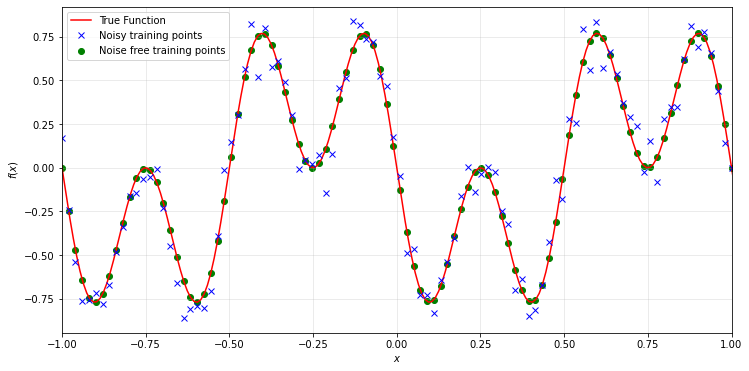

In [2]:
# True function we want to learn from data. Assume we don't know it.

def f(X):
    return -np.cos(2*np.pi*X)* + np.sin(4*np.pi*X)


npoints = 100 # size of training set
noise_variance = 0.01 # variance of noise

# Generate training data
X = np.linspace(-1,1,npoints)[:,None]
F = f(X)
noise = np.random.randn(npoints,1) * np.sqrt(noise_variance)
Y = F + noise

# Generate data for plotting purposes
X_true = np.linspace(-5,5,1000)[:,None]
Y_true = f(X_true)


# plot
plt.figure(figsize=(12,6))
plt.plot(X_true,Y_true,'r')
plt.plot(X,Y,'bx',ms=6)
plt.scatter(X,F,color='green')
plt.legend(['True Function','Noisy training points','Noise free training points'],loc='best')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim([-1,1])
plt.grid(alpha=0.3)

# Green dots => y value of each X

# Bayesian non-linear Regression

To find the regression model for the previous data using nonlinear Bayesian regression:
1. Select a RBF kernel 
$\kappa(x_i, x_j) = \exp(-\gamma(x_i-x_j)^2)$

2. Select a noise level $\sigma_n^2$

3. Learn the predictive distibution

- mean:
$$
\mathbb E\{y_t\} = \mathbf h(\mathbf x_t)^\top\mathbb E\{\mathbf w\} = \mathbf h(\mathbf x_t)^{\top}\mathbf m_{\mathbf w} = \mathbf h(\mathbf x_t)^{\top} \Sigma_pH^\top (K + \sigma_n^2\mathbb I)^{-1}\mathbf y
$$
- variance
$$
\mathbf h(\mathbf x_t)^{\top} \Sigma_{\mathbf w} \mathbf h(\mathbf x_t)=\mathbf h(\mathbf x_t)^{\top} \left( \Sigma_p - \Sigma_pH^\top(K + \sigma_n^2\mathbb I)^{-1}H\Sigma_p \right) \mathbf h(\mathbf x_t)
$$
Introducing again the kernel $\kappa(\mathbf x_i, \mathbf x_j) = \mathbf h(\mathbf x_i)^{\top} \Sigma_p \mathbf h(\mathbf x_j)$ 
- mean of $y_t$:
$$
\mathbf k_t^{\top} (K + \sigma_n^2\mathbb I)^{-1}\mathbf y
$$
- variance of $y_t$
$$
k_{tt} - \mathbf k_t^\top(K + \sigma_n^2\mathbb I)^{-1}\mathbf k_t
$$
where 
$$\mathbf k_t = H\Sigma_p \mathbf h(\mathbf x_t) = \left[\begin{array}{c}\kappa(\mathbf x_t, \mathbf x_1)\\ \vdots \\\kappa(\mathbf x_t, \mathbf x_N)\end{array}\right]$$ is a vector with the kernel between $\mathbf x_t$ and all the training observations,  and $k_{tt} = \kappa(\mathbf x_t, \mathbf x_t)$

In [3]:
from sklearn.metrics.pairwise import rbf_kernel

def predictive_distribution(X, Y, Xt, kernel,gamma=1.0,sigma_n=1.):
    N = len(Y)
    Ng = Xt.shape[0]
    sn2 = sigma_n**(2)
    X1 = X.reshape(-1,1)
    KK = kernel(X1,gamma=gamma)
    iKS = np.linalg.inv(KK + sn2*np.eye(N))

    Xg1 = Xt.reshape(-1,1)
    kt = kernel(Xg1, X1, gamma)

    my = kt.dot(iKS).dot(Y.reshape(-1,1)).flatten()

    # sqrt to obtain the standard deviation for plotting
    sy = np.sqrt((np.ones((Ng,1)) - np.sum((kt.dot(iKS)) * kt, 1).reshape(-1,1)).flatten())

    return my, sy

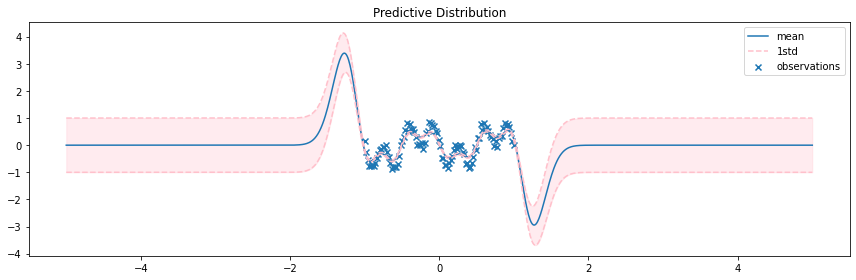

In [4]:
my_sigma_noise = .1

my, sy = predictive_distribution(X, Y, X_true, 
                                 rbf_kernel,
                                 gamma=10,
                                 sigma_n=my_sigma_noise)
fa, ak = plt.subplots(1,1,figsize=(12,4))
ak.plot(X_true,my,label='mean')
ak.plot(X_true,my+sy,label='1std',linestyle='--',color='pink')
ak.plot(X_true,my-sy,linestyle='--',color='pink')
ak.fill_between(X_true.flatten(), my-sy, my+sy,alpha=0.3,color='pink')
ak.scatter(X,Y,marker='x',label='observations')
ak.set_title('Predictive Distribution')
ak.legend()
fa.tight_layout()

## Gaussian Process for regression in sklearn

### Gaussian Process definition
- Consider $f(\mathbf x)$ a vector of infinite dimensions
- Consider the elements in $f(\mathbf x)$ follow a **joint Gaussian pdf**. Therefore this Gaussian Process is defined by two functions, its **two statistics**:
   - **mean** $\rightarrow$ **mean function** $\mathbb E\{f(\mathbf x)\} = m(\mathbf x)$. Given an input $\mathbf x_i$ you can compute the mean of $f(\mathbf x_i)$ as $m(\mathbf x_i)$. One usually  takes $m(\mathbf x)=0$

  - **variance** $\rightarrow$ **covariance function**
$$\kappa(\mathbf x_i, \mathbf x_j)=\mathbb E\{(f(\mathbf x_i) - m(\mathbf x_i)) (f(\mathbf x_j) - m(\mathbf x_j))\}$$

### Data generation with a GP
0. GET THE Xs

1. To generate the data for the the non-linear regression problem with Gaussian Processes the data generation agent first picks a **mean function** and a **covariance function** to define the GP.

2. **Draw a particular** function $f()$ from the Gaussian Process

3. In the **noise-free** case, the observed targets are generated using 
$$
y_i = f(\mathbf x_i)
$$ In the case **with noise** the targets are generated with $$
 y_i = f(\mathbf x_i) +   \epsilon \qquad  \epsilon \sim \mathcal N(0,\sigma_n^2)
$$

4. The data generation process outputs a $N\times d$ matrix $X$ with an input per row and a vector $\mathbf y$ with $N$ elements, and $y_i$ is the target that corresponds to the input in the $i$-th row of $X$. 

### Gaussian Process Regression

1. Select a kernel function. This will act as covariance function of the GP. If you consider noise in your data, you should include a noise component in the kernel function.

2. Select a mean function. One usually chooses 0 mean GPs. The usual case is to introduce a mean term in the kernel function, rather than a mean function.

3. Form the predictive posterior distribution

#### 3.1 Predictive distribution in the noise free case


With the mean and covariance functions of the Gaussian Process we can reconstruct the mean and covariance of the joint distribution of the training and test observations
$$
p\left(\left[\begin{array}{c}\mathbf y\\\mathbf y_t \end{array}\right]\right) = \mathcal N\left( \left[\begin{array}{c}\mathbf m(X)\\\mathbf m(X_t) \end{array}\right],  \left[\begin{array}{cc} K(X,X) & K(X,X_t) \\ K(X_t,X) & K(X_t,X_t)\end{array}\right]\right )
$$

The predictive distribution is the conditional 
$$
p(\mathbf y_t | X_t,X,\mathbf y) = \mathcal N(\mathbf m(X_t)+K_t^\top K ^{-1}(\mathbf y-\mathbf m(X)), K_{tt}-K_t^\top K^{-1} K_t)
$$

If you chose a zero mean function:

$$
p(\mathbf y_t | X_t,X,\mathbf y) = \mathcal N(K_t^\top K ^{-1}\mathbf y, K_{tt}-K_t^\top K^{-1} K_t)
$$ Therefore the mean of the prediction for all the test observations is
$$
\mathbb E\{\mathbf y_t\} = K_t^\top K ^{-1}\mathbf y 
$$
and the covariance
$$
\mbox{cov}(\mathbf y_t) = K_{tt}-K_t^\top K^{-1} K_t
$$Notice how the covariance only depends on $X$, it does not depend of the values of $\mathbf y$.

#### 3.2 Predictive distribution in the case with noise

$$
p\left(\left[\begin{array}{c}\mathbf y\\\mathbf f_t \end{array}\right]\right) = \mathcal N\left( \left[\begin{array}{c}\mathbf m(X)\\\mathbf m(X_t) \end{array}\right],  \left[\begin{array}{cc} K(X,X) + \sigma_n^2\mathbb I & K(X,X_t) \\ K(X_t,X) & K(X_t,X_t)\end{array}\right]\right )
$$

The predictive distribution is the conditional 
$$
p(\mathbf f_t | X_t,X,\mathbf y) = \mathcal N(\mathbf m(X_t)+K_t^\top (K+ \sigma_n^2\mathbb I)^{-1}(\mathbf y-\mathbf m(X)), K_{tt}-K_t^\top (K+ \sigma_n^2\mathbb I)^{-1} K_t)
$$
Remarks for the zero mean case. **For a single test observation:**
- $\mathbf m(f_t) = \mathbf k_t^\top (K+ \sigma_n^2\mathbb I)^{-1}\mathbf y$ is a linear combination of the training targets $\mathbf y$. The contribution of observation $y_i$ in the prediction for $y_t$ is weighted by the kernel $\kappa(\mathbf x_i, \mathbf x_t)$
- The covariance $K_{tt}-K_t^\top (K+ \sigma_n^2\mathbb I)^{-1} K_t$ **does not depend on the targets either**, just on how close is $\mathbf x_t$ from the training observations (distance measured through the kernel function).





## Example end-to-end with a Gaussian Process

### Gaussian Process data generation

Text(0.5, 1.0, 'True function')

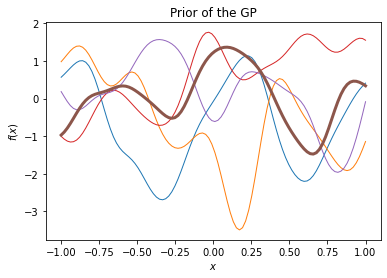

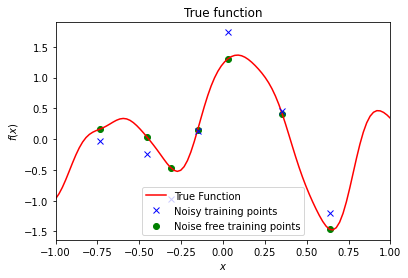

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import  RBF, WhiteKernel

# variance of the noise in the data generation process
noise_variance = .1

# instantiate the kernel
kernel = RBF(length_scale=.15)

# instantiate the GP (prior on f)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

# X of the data for plotting
xg = np.linspace(-1,1,100)[:,None]

# Draw 5 functions at random from the GP and evaluate them in xg
Yg = gpr.sample_y(xg, 5)

# plot the 5 functions
plt.figure()
plt.plot(xg, Yg,lw=1)

# stress one of the functions
yg = Yg[:,2]
plt.plot(xg, yg,lw=3)

plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Prior of the GP')

# Training set, just pick 7 positions of X (indexed by [13, 27, 34, 42, 51, 67, 81])
# and also the respective values of f(x) for those 7 inputs
X = xg[[13, 27, 34, 42, 51, 67, 81]]
F = yg[[13, 27, 34, 42, 51, 67, 81]][:,None]

# generate the noise
noise = np.random.randn(len(F),1) * np.sqrt(noise_variance)
# add noise to observations
Y = F + noise

plt.figure()
plt.plot(xg,yg,'r')
plt.plot(X,Y,'bx',ms=6)
plt.scatter(X,F,color='green')
plt.legend(['True Function','Noisy training points','Noise free training points'])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim([-1,1])
plt.title('True function')


# When u sample a gaussian u get functions
# 

### Learn the Gaussian Process from training data

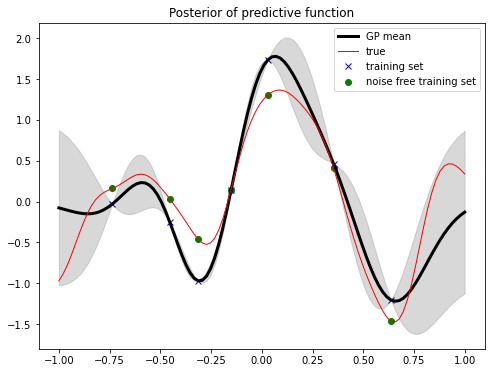

In [8]:
# first instantiate a kernel. Notice its parameter does not have to be the original one
kernel_1 = RBF(length_scale=.05)

# instantiate GP
gpr2 = GaussianProcessRegressor(kernel=kernel_1, random_state=0)

# fit
gpr2.fit(X,Y)

# predict. Notice it returns two outputs, mean and variance 
y_mean, y_cov = gpr2.predict(xg, return_cov=True)
# When predict you get mean and variance!!!

# plot

plt.figure(figsize=(8,6))
my = y_mean.flatten() # mean of predictive distribution
sy = np.sqrt(np.diag(y_cov)).flatten() # variance of predictive distribution
plt.plot(xg, my, 'k', lw=3, zorder=9, label='GP mean')
plt.fill_between(xg.flatten(), my-sy ,
                 my + sy,
                 alpha=0.3, color='gray')
plt.plot(xg, yg, 'r', lw=1, zorder=9, label='true')
plt.plot(X,Y,'bx',ms=6,label='training set')
plt.title('Posterior of predictive function')
plt.scatter(X,F,color='green', label='noise free training set')
_=plt.legend()

# Kernels for Gaussian Processes 

The kernel is the core contribution for the Gaussian Process. Some of the most used kernels are:

- RBF kernel
$$
\kappa(\mathbf x_i, \mathbf x_j) = \exp\left(-\frac{1}{2l^2}\|\mathbf x_i - \mathbf x_j\|^2\right)
$$ Notice that there is a difference with the RBF kernel implementation we saw for the SVM: $\gamma = \frac{1}{2l^2}$

- ARD (Automatic Relevance Determination) kernel. 
  In the implementation of scikit learn the ARD kernel is instantiated by calling the RBF constructor with an array of length scales, one per each input variable
  $$
  \kappa(\mathbf x_i, \mathbf x_j) = \exp\left(-\frac{1}{2}\sum_{k=1}^d \frac{(x_{i,k} -x_{j,k})^2}{l_k^2}\right)
  $$

- Constant kernel: 
$$
\kappa(\mathbf x_i, \mathbf x_j) = c
$$

- White noise kernel. Usually composed in a sum with other kernels to model additive white noise with noise level $\sigma_n^2$
$$
\kappa(\mathbf x_i, \mathbf x_j) = \sigma_n^2\delta(\mathbf x_i, \mathbf x_j)
$$

- Absolute exponential kernel
$$
\kappa(\mathbf x_i, \mathbf x_j) = \exp\left(-\frac{1}{l}|\mathbf x_i - \mathbf x_j|\right)
$$
- Matérn kernel:
$$
\kappa(\mathbf x_i, \mathbf x_j) = \frac{1}{\Gamma(\nu)2^{nu -1}}\left(\frac{\sqrt{2\nu}}{l}|\mathbf x_i - \mathbf x_j|\right)^\nu K_{\nu}\left(\frac{\sqrt{2\nu}}{l}|\mathbf x_i - \mathbf x_j|\right)
$$where $K_{\nu}()$ is a modified Bessel function and $\Gamma()$ is the Gamma function. As $\nu\rightarrow \infty$ the Matérn kernel converges to the RBF kernel. The parameter $\nu$ controls the smoothness of the learned function

- Rational quadratic kernel:
$$
\kappa(\mathbf x_i, \mathbf x_j) =\left(1+\frac{|\mathbf x_i - \mathbf x_j|^2}{2\alpha l^2}\right)^{-\alpha}
$$

- Exp-Sine-Squared kernel
$$
\kappa(\mathbf x_i, \mathbf x_j) =\exp\left(-\frac{2\sin^2(\pi|\mathbf x_i - \mathbf x_j|/p)}{l^2}\right)
$$

- Dot-product kernel: 
$$
\kappa(\mathbf x_i, \mathbf x_j) = \sigma_0^2 + \mathbf x_i^\top \mathbf x_j
$$

## Examples with Sklearn



(-1.0, 1.0)

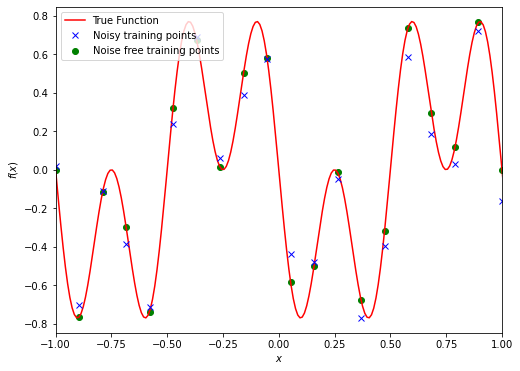

In [9]:
# true function we want to learn from data
def f(X):
    return -np.cos(2*np.pi*X)* + np.sin(4*np.pi*X)

# size of training set
npoints = 20

# noise variance to generate data
noise_variance = 0.01

# position of training observations
X = np.linspace(-1,1,npoints)[:,None]

# compute the targets for the training observations
F = f(X)
noise = np.random.randn(X.shape[0],1) * np.sqrt(noise_variance)
y = F + noise

# for plotting lines and curves
X_ = np.linspace(-5,5,1000)[:,None]
Y_ = f(X_)

plt.figure(figsize=(8,6))
plt.plot(X_,Y_,'r')
plt.plot(X,y,'bx',ms=6)
plt.scatter(X,F,color='green')
plt.legend(['True Function','Noisy training points','Noise free training points'])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim([-1,1])

# In gaussian processes we do not do cross validation
# 

In [10]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel,WhiteKernel)




kernel: RBF



/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


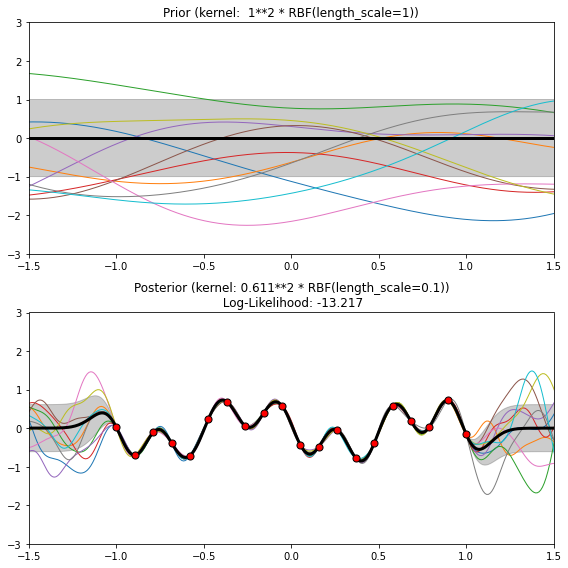




kernel: Rational Quadratic



/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


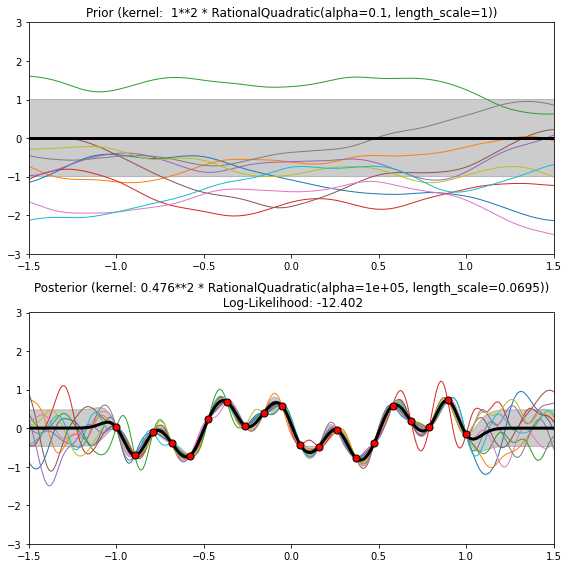




kernel: Exp-Sine-Squared



/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


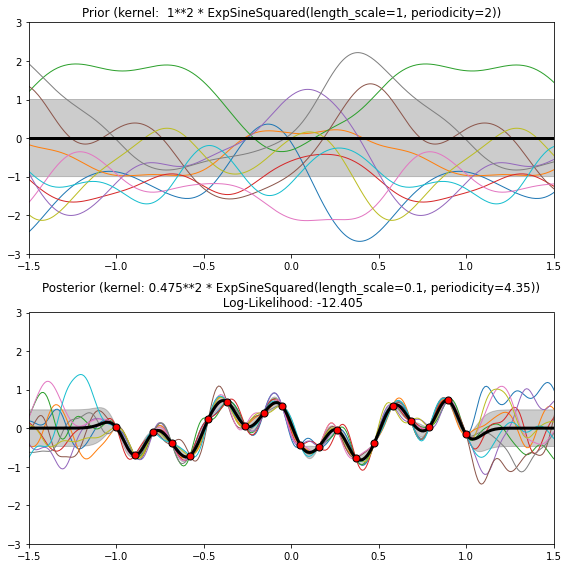




kernel: Dot Product



/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


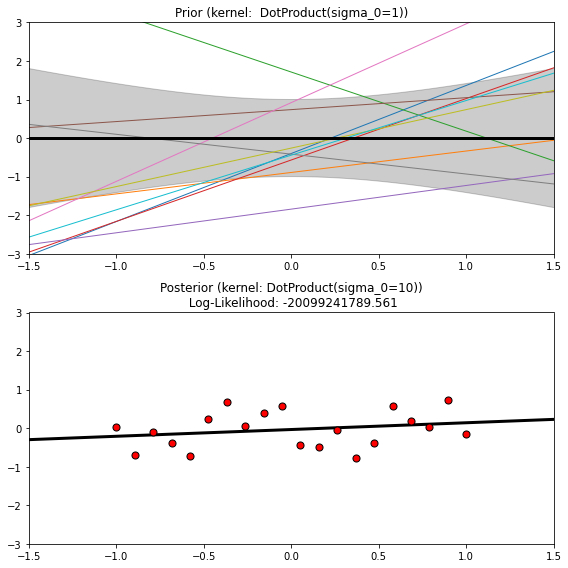




kernel: Matern



/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


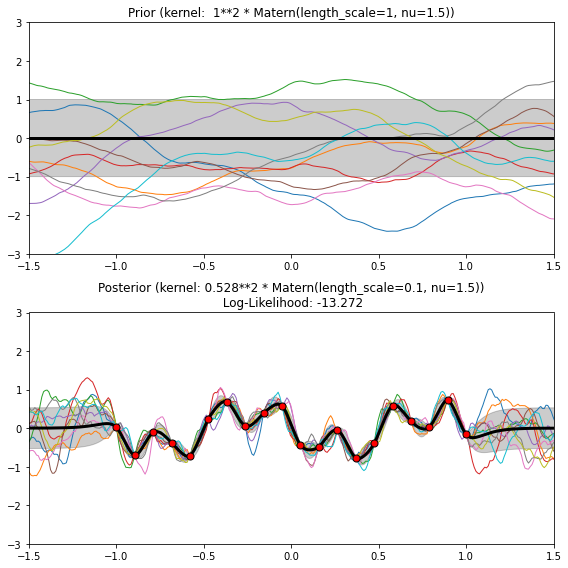

In [11]:


k_name = ['RBF', 'Rational Quadratic', 'Exp-Sine-Squared', 'Dot Product','Matern']
kernels = [1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)),
           1.0 * RationalQuadratic(length_scale=1.0, alpha=0.1),
           1.0 * ExpSineSquared(length_scale=1.0, periodicity=2.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)),
           DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)),
           1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0),
                        nu=1.5)]

for ik,kernel in enumerate(kernels):
    print("")
    print("")
    print("")

    # Specify Gaussian Process
    gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)
    print("kernel: {0}".format(k_name[ik]))
    print("")
    # Plot prior
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    
    # Predict before fit
    y_mean, y_std = gp.predict(X_, return_std=True)
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_.flatten(), y_mean - y_std, y_mean + y_std,
                     alpha=0.2, color='k')
    y_samples = gp.sample_y(X_, 10)
    plt.plot(X_, y_samples, lw=1)
    plt.xlim(-1.5, 1.5)
    plt.ylim(-3, 3)
    plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)
    
    
    gp.fit(X, y)

    # Plot posterior
    plt.subplot(2, 1, 2)
    
    y_mean, y_std = gp.predict(X_, return_std=True)
    my = y_mean.flatten()
    sy = y_std.flatten()
    plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
    plt.fill_between(X_.flatten(), my - sy, my + sy,
                     alpha=0.2, color='k')

    y_samples = gp.sample_y(X_, 10)
    plt.plot(X_, y_samples.reshape((len(X_),10)), lw=1)
    plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
    plt.xlim(-1.5, 1.5)
    plt.ylim(-3, 3)
    plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
              % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
              fontsize=12)
    plt.tight_layout()
    plt.show()

plt.show()

Combinations of kernels

/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__periodicity is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__k2__sigma_0 is close to the specified lower bound 0.1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may 

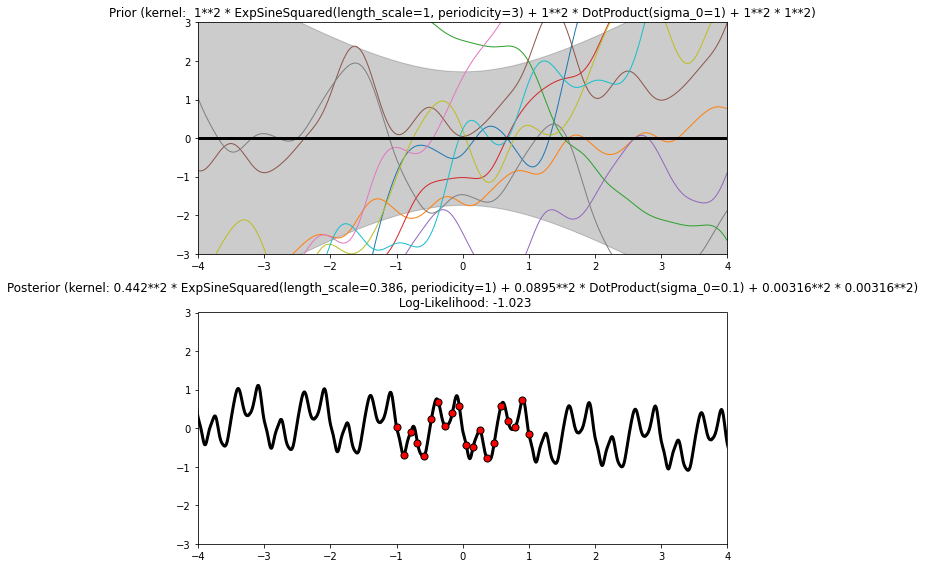

In [12]:
kernel =  1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0)) + 1.0 * DotProduct(sigma_0=1.0, sigma_0_bounds=(0.1, 10.0)) + 1.0*ConstantKernel()
# Specify Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=10)

# Plot prior
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)

y_mean, y_std = gp.predict(X_, return_std=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_.flatten(), y_mean - y_std, y_mean + y_std,
                  alpha=0.2, color='k')
y_samples = gp.sample_y(X_, 10)
plt.plot(X_, y_samples, lw=1)
plt.xlim(-4, 4)
plt.ylim(-3, 3)
plt.title("Prior (kernel:  %s)" % kernel, fontsize=12)


gp.fit(X, y)

# Plot posterior
plt.subplot(2, 1, 2)

y_mean, y_std = gp.predict(X_, return_std=True)
my = y_mean.flatten()
sy = y_std.flatten()
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_.flatten(), my - sy, my + sy,
                  alpha=0.2, color='k')

y_samples = gp.sample_y(X_, 10)
plt.plot(X_, y_samples.reshape((len(X_),10)), lw=1)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.xlim(-4, 4)
plt.ylim(-3, 3)
plt.title("Posterior (kernel: %s)\n Log-Likelihood: %.3f"
          % (gp.kernel_, gp.log_marginal_likelihood(gp.kernel_.theta)),
          fontsize=12)

plt.tight_layout()
plt.show()


## Example with ARD kernel

First we choose a regression in 2D in which the two components of the observation present similar covariances with the target.

In [13]:
from mpl_toolkits.mplot3d import Axes3D 

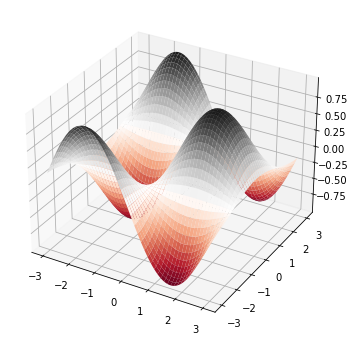

In [14]:
# True surface
intervals = 200
a = np.linspace(-3, 3, intervals)
b = np.linspace(-3, 3, intervals)

C,D = np.meshgrid(a,b)

cyd = np.vstack([C.ravel(), D.ravel()]).T

Z = np.sin(cyd[:,0])* np.cos(cyd[:,1])

Z = Z.reshape([intervals,intervals])

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
_=ax.plot_surface(C, D, Z, cmap='RdGy')

In [15]:
def mi_f(X):
    return np.sin(X[:,0]) * np.cos(X[:,1])

Text(0.5, 1.0, 'Data sampled and learned GP')

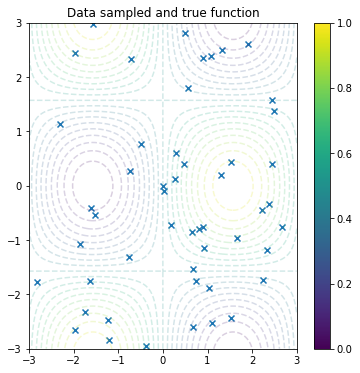

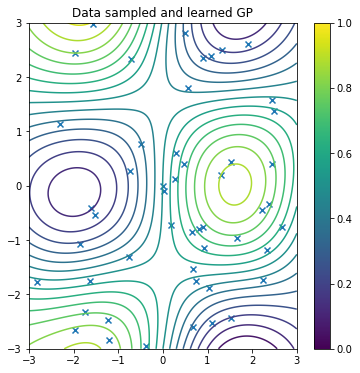

In [16]:
# sample noisy training points
npoints = 50
X = np.random.uniform(-3.,3.,(npoints,2))
Y = mi_f(X)+np.random.randn(npoints,)*np.sqrt(0.01)



# define kernel
kernel = RBF(length_scale = 2*np.ones(2), length_scale_bounds=(.001,10)) + WhiteKernel()

# create simple GP model
m3 = GaussianProcessRegressor(kernel=kernel).fit(X,Y.reshape([-1,1]))

Xg = np.linspace(-3, 3, 500) # or whatever values for x
XX, YY = np.meshgrid(Xg, Xg)
Xshape = XX.shape
x_test = np.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))

plt.figure(figsize=(6,6))
plt.contour(Xg, Xg, mi_f(x_test).reshape(Xshape),20, alpha=0.2,linestyles='dashed')
plt.scatter(X[:,0],X[:,1],marker='x')
plt.colorbar()
plt.title('Data sampled and true function')



zz = m3.predict(x_test).reshape(Xshape)
plt.figure(figsize=(6,6))
plt.contour(Xg, Xg, zz,20)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.colorbar()
plt.title('Data sampled and learned GP')



Since both input variables $x_1$ and $x_2$ are informative, the ARD kernel gives values to their `length_scale` parameters in the same order of magnitude

In [30]:
print(m3.kernel_)

RBF(length_scale=[1.83, 1.63]) + WhiteKernel(noise_level=0.00778)


Now we study a regression in 2D in which there is an input variable that present a significantly stronger covariance with the target than the other.

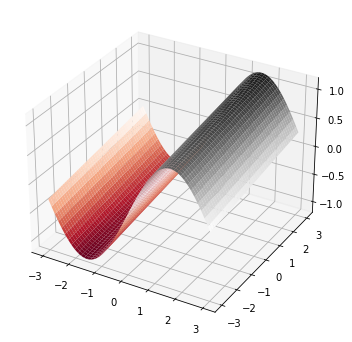

In [31]:
# True surface
intervals = 200
a = np.linspace(-3, 3, intervals)
b = np.linspace(-3, 3, intervals)

C,D = np.meshgrid(a,b)

cyd = np.vstack([C.ravel(), D.ravel()]).T

Z = np.sin(cyd[:,0])+ 0.05*(cyd[:,1])

Z = Z.reshape([intervals,intervals])

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(C, D, Z, cmap='RdGy')

#Change in y axis more than in x axis

/opt/homebrew/Caskroom/miniforge/base/envs/test_env/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


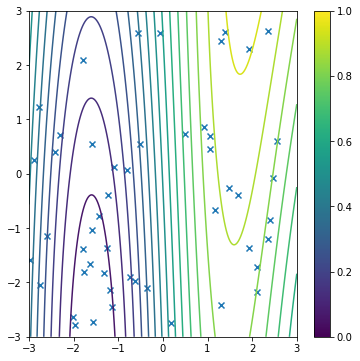

In [32]:
# sample noisy training points
npoints = 50
X = np.random.uniform(-3.,3.,(npoints,2))
Y = np.sin(X[:,0:1]) + 0.05*X[:,1:2]+np.random.randn(npoints,1)*np.sqrt(0.01)

# define kernel
kernel = RBF(length_scale = 2*np.ones(2), length_scale_bounds=(.001,10)) + WhiteKernel()

# create simple GP model
m4 = GaussianProcessRegressor(kernel=kernel).fit(X,Y.reshape([-1,1])) # Also fit the gaussian parameters of the cernel

Xg = np.linspace(-3, 3, 500) # or whatever values for x
XX, YY = np.meshgrid(Xg, Xg)
Xshape = XX.shape

x_test = np.hstack((XX.reshape(-1,1), YY.reshape(-1,1)))
zz = m4.predict(x_test).reshape(Xshape)
plt.figure(figsize=(6,6))
plt.contour(Xg, Xg, zz,20)
plt.scatter(X[:,0],X[:,1],marker='x')
plt.colorbar()

Notice how the GP learns a significantly larger length scale for the variable that presents a weaker covariance with the target

In [25]:
print(m4.kernel_) # [small change, large change] -> [small change leads to more change in the kernel, not so informative]

RBF(length_scale=[1.44, 10]) + WhiteKernel(noise_level=0.00643)


# Gaussian Processes for classification
## Linear Models for classification

The way to address the binary classification problem from a probabilistic framework is to learn $p(y=+1|\mathbf x)$, that is, the **posterior probability** of one of the output classes (notice $p(y=+1|\mathbf x) + p(y=-1|\mathbf x) = 1$)

A straightforward way is to learn a linear model squashed with a sigmoid function
$$
p(y=+1|\mathbf x) = \sigma(\mathbf w^\top \mathbf x)
$$ with
$$
\sigma(z) = \frac{1}{1+\exp(-z)}
$$ or
$$
\sigma(z) = \int_{-\infty}^z\mathcal N(\tau|0,1) d\tau
$$

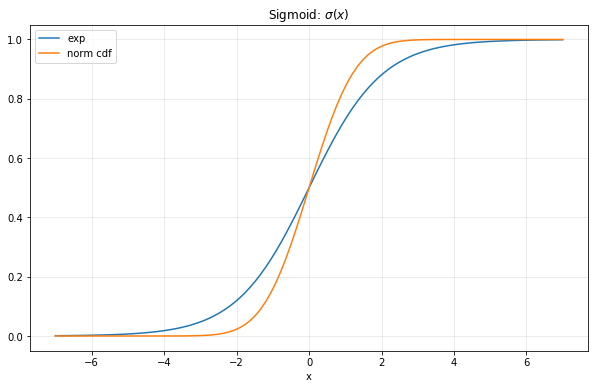

In [ ]:
from scipy.stats import norm
x = np.linspace(-7,7,100)
plt.figure(figsize=(10,6))
s1 = 1./(1 + np.exp(-x))
s2 = norm.cdf(x)
plt.plot(x, s1, label='exp')
plt.plot(x, s2,label='norm cdf')
plt.xlabel('x')
plt.grid(alpha=0.3)
plt.legend()

_=plt.title('Sigmoid: $\\sigma(x)$')

The rationale under the use of the sigmoid functions is that the smaller the value of the latent function, the smaller the posterior of class $y=+1$ and conversely, the larger the value of the latent function, the larger the posterior of class $y=+1$.

Then one can think about a **latent model** in which a process $\mathbf f$ is used to generate the true class for every observation. 

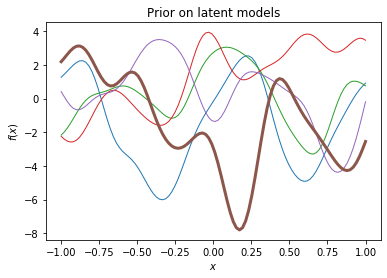

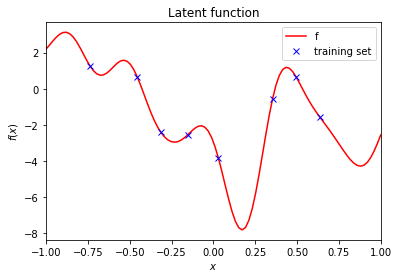

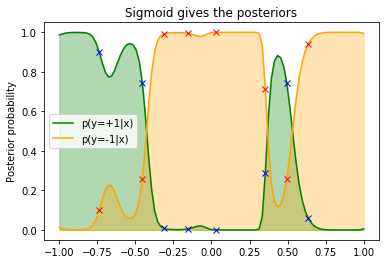

In [ ]:


noise_variance = .1
kernel = 5*RBF(length_scale=.15)
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
xg = np.linspace(-1,1,100)[:,None]
Yg = gpr.sample_y(xg, 5)
plt.figure()
plt.plot(xg, Yg,lw=1)
yg = Yg[:,1]
plt.plot(xg, yg,lw=3)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Prior on latent models')


X = xg[[13, 27, 34, 42, 51, 67, 74, 81]]
Y = yg[[13, 27, 34, 42, 51, 67, 74, 81]]
plt.figure()
plt.plot(xg,yg,'r',label='f')
plt.plot(X,Y,'bx',ms=6,label='training set')


plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.title('Latent function')
plt.legend()
plt.xlim([-1,1])

plt.figure()
plt.title('Sigmoid gives the posteriors')
plt.plot(xg,norm.cdf(yg),'g', label="p(y=+1|x)")
plt.fill_between(xg.flatten(),np.zeros(xg.shape[0]),norm.cdf(yg),color='green',alpha=0.3)
plt.plot(X,norm.cdf(Y),'bx',ms=6)
plt.plot(xg,1-norm.cdf(yg),color='orange',label='p(y=-1|x)')
plt.fill_between(xg.flatten(),np.zeros(xg.shape[0]),1-norm.cdf(yg),color='orange',alpha=0.3)

plt.plot(X,1-norm.cdf(Y),'rx',ms=6)
plt.ylabel('Posterior probability')
plt.legend()



## Predictive distribution

For each test observation, the **predictive distribution** helps you find out the posterior probability of each class.

The predictive distribution is determined in two steps:
1. Determine the **posterior of the latent function** on the test samples
$$
p(\mathbf f_t|X, \mathbf y, X_t) = \int{p(\mathbf f_t| \mathbf f, \mathbf X_t)p(\mathbf f|\mathbf y, X)d\mathbf f}
$$
$$
p(\mathbf f|\mathbf y, X) = \frac{p(\mathbf y|\mathbf f)p(\mathbf f|X)}{p(\mathbf y|X)} = \frac{\prod_{i=1}^N\sigma(f(\mathbf x_i)) \mathcal N(\mathbf f|\mathbf 0,K)}{ \int{\prod_{i=1}^N\sigma(f(\mathbf x_i)) \mathcal N(\mathbf f|\mathbf 0,K) d \mathbf f}}
$$ which are not Gaussian pdfs...

Note: we have used 
$$
p(\mathbf y|\mathbf f) = \left[\begin{array}{c} p(y_1=+1|\mathbf f) \\ p(y_2=+1|\mathbf f) \\ \vdots \\ p(y_N=+1|\mathbf f) \end{array}\right] = \left[\begin{array}{c} \sigma(f(\mathbf x_1)) \\ \sigma(f(\mathbf x_2)) \\ \vdots \\ \sigma(f(\mathbf x_N)) \end{array}\right]
$$
2. Determine the probability of the class
$$
p(y_t=+1|X,\mathbf y_t,\mathbf x_t) = \int{\sigma(f(\mathbf x_t))p(f(\mathbf x_t)|X, \mathbf y, \mathbf x_t)df(\mathbf x_t)}
$$ The above integral is intractable, so one needs to resource to numerical approximations in order to evaluate it.

### Laplace approximation

Construct a Gaussian approximation to the posterior of the latent function
$$
q(\mathbf f|X,\mathbf y) = \mathcal N(\mathbf f|\hat{\mathbf f}, A^{-1}) \approx p(\mathbf f|X,\mathbf y)
$$where $\hat{\mathbf f} = \mbox{argmax}_{\mathbf f}p(\mathbf f|X,\mathbf y)$ and $A$ is the Hessian of the negative log posterior 
$$
\mbox{The posterior is }p(\mathbf f|X,\mathbf y) \propto p(\mathbf y|\mathbf f) p(\mathbf f|X) $$
taking logs:
$$
l(\mathbf f) = \log  p(\mathbf y|\mathbf f) -\frac{1}{2}\mathbf f^\top K^{-1}\mathbf f-\frac{1}{2}\log{|K|}-\frac{d}{2}\log(2\pi)$$

The gradient of $l(\mathbf f)$ is zero at the position of the maximum $\hat{\mathbf f}$

$$
\nabla l(\hat{\mathbf f}) = 0 = \nabla \log p(\mathbf y|\mathbf f)|_{\hat{\mathbf f}} - K^{-1}\hat{\mathbf f}
$$therefore
$$
\hat{\mathbf f} = K\nabla \log p(\mathbf y|\mathbf f)|_{\hat{\mathbf f}}
$$

that has to be solved numerically. Then the covariance matrix of the local Laplace approximation is given by the Hessian
$$
\nabla\nabla \log p(\mathbf y|\mathbf f)|_{\hat{\mathbf f}} = W(\hat{\mathbf f}) - K^{-1}
$$where $W$ is a diagonal matrix with elements $\sigma(f_n)(1-\sigma(f_n))$



In summary 
$$
p(\mathbf f|X,\mathbf y) \approx \mathcal N(\hat{\mathbf f}, (K^{-1}-W)^{-1})
$$ that lead to tractable integrals for inference

### Predictive distributions in classification
- Latent mean

$$
\mathbb E_q [f_t|X,\mathbf y, \mathbf x_t] = \mathbf k_t^{\top}K^{-1}\hat{\mathbf f}
$$ 
where $\mathbf k_t$ is the kernel between the test observation $\mathbf x_t$ and all the training set observations
- Latent variance
$$
\mathbb V_q[f_t|X,\mathbf y, \mathbf x_t] = k_{tt} - \mathbf k_t^{\top}(K+W^{-1})^{-1}\mathbf k_t
$$where $k_{tt}$ is the kernel of the the test observation $\mathbf x_t$  with itself
- Predictive mean of the probability of class +1
$$
p(y_t=+1|X,\mathbf y,\mathbf x_t) = \int{\sigma(f_t)q(f_t|X,\mathbf y, \mathbf x_t)df_t}
$$where $q(f_t|X,\mathbf y, \mathbf x_t)$ is a Gaussian with mean $\mathbb E_q [f_t|X,\mathbf y, \mathbf x_t]$ and variance $\mathbb V_q[f_t|X,\mathbf y, \mathbf x_t]$


## Example of classification with Gaussian Processes

### Data generation process

In [21]:
# Generate data
train_size = 20
rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 100)[:, np.newaxis]
y = np.array(X[:, 0] > 2.5, dtype=int)


## GP from sklearn

Log Marginal Likelihood (initial): -9.657
Log Marginal Likelihood (optimized): -3.536
Accuracy: 1.000 (initial) 1.000 (optimized)
Log-loss: 0.328 (initial) 0.325 (optimized)


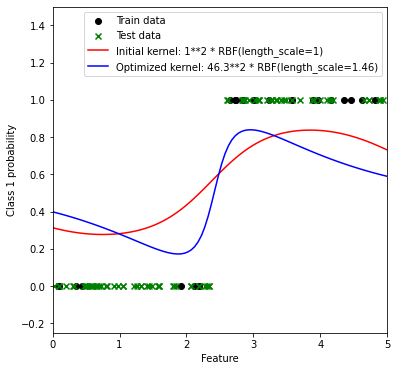

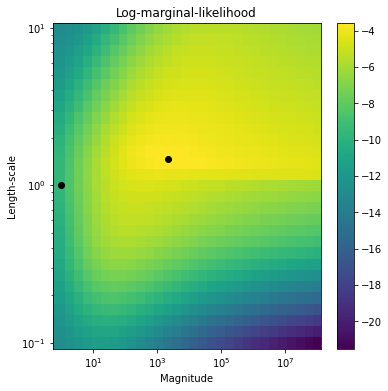

In [22]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF



# Specify Gaussian Processes with fixed and optimized hyperparameters
gp_fix = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0),
                                   optimizer=None)
gp_fix.fit(X[:train_size], y[:train_size])

gp_opt = GaussianProcessClassifier(kernel=1.0 * RBF(length_scale=1.0))
gp_opt.fit(X[:train_size], y[:train_size])

print("Log Marginal Likelihood (initial): %.3f"
      % gp_fix.log_marginal_likelihood(gp_fix.kernel_.theta))
print("Log Marginal Likelihood (optimized): %.3f"
      % gp_opt.log_marginal_likelihood(gp_opt.kernel_.theta))

print("Accuracy: %.3f (initial) %.3f (optimized)"
      % (accuracy_score(y[:train_size], gp_fix.predict(X[:train_size])),
         accuracy_score(y[:train_size], gp_opt.predict(X[:train_size]))))
print("Log-loss: %.3f (initial) %.3f (optimized)"
      % (log_loss(y[:train_size], gp_fix.predict_proba(X[:train_size])[:, 1]),
         log_loss(y[:train_size], gp_opt.predict_proba(X[:train_size])[:, 1])))


# Plot posteriors
plt.figure(figsize=(6,6))
plt.scatter(X[:train_size, 0], y[:train_size], c='k', label="Train data")
plt.scatter(X[train_size:, 0], y[train_size:], marker='x', c='g', label="Test data")
X_ = np.linspace(0, 5, 100)
plt.plot(X_, gp_fix.predict_proba(X_[:, np.newaxis])[:, 1], 'r',
         label="Initial kernel: %s" % gp_fix.kernel_)
plt.plot(X_, gp_opt.predict_proba(X_[:, np.newaxis])[:, 1], 'b',
         label="Optimized kernel: %s" % gp_opt.kernel_)
plt.xlabel("Feature")
plt.ylabel("Class 1 probability")
plt.xlim(0, 5)
plt.ylim(-0.25, 1.5)
plt.legend(loc="best")

# Plot LML landscape
plt.figure(figsize=(6,6))
theta0 = np.logspace(0, 8, 30)
theta1 = np.logspace(-1, 1, 29)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp_opt.log_marginal_likelihood(np.log([Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T
plt.plot(np.exp(gp_fix.kernel_.theta)[0], np.exp(gp_fix.kernel_.theta)[1],
         'ko', zorder=10)
plt.plot(np.exp(gp_opt.kernel_.theta)[0], np.exp(gp_opt.kernel_.theta)[1],
         'ko', zorder=10)
plt.pcolor(Theta0, Theta1, LML)
plt.xscale("log")
plt.yscale("log")
plt.colorbar()
plt.xlabel("Magnitude")
plt.ylabel("Length-scale")
plt.title("Log-marginal-likelihood")

plt.show()

## Example in 2D


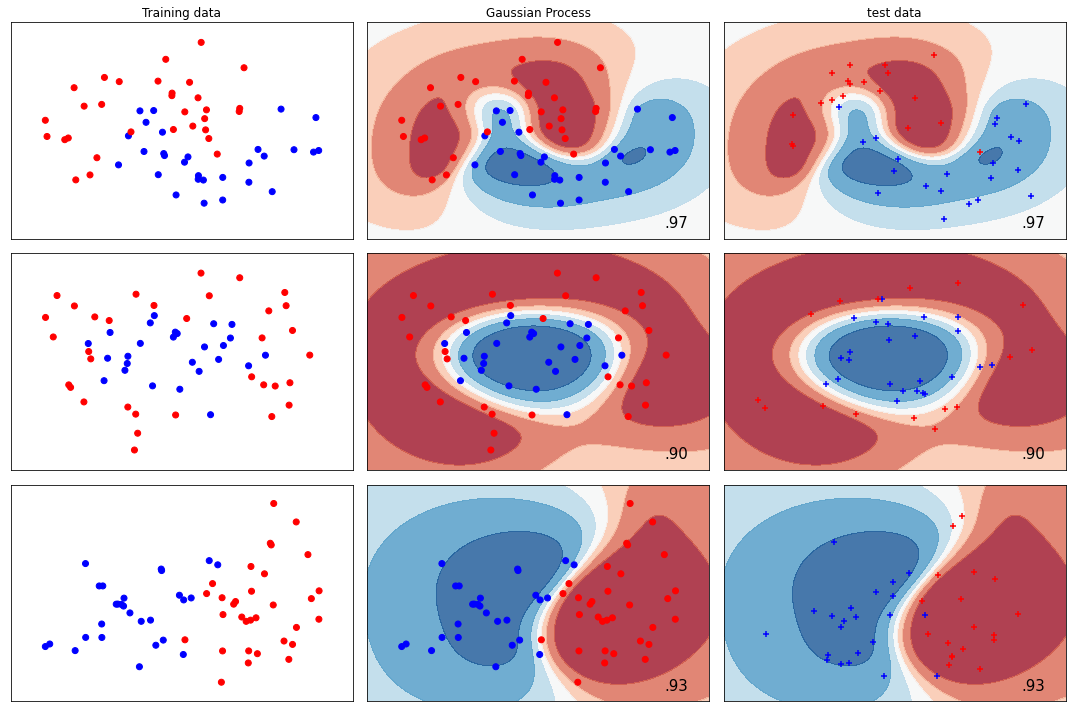

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification


h = .02  # step size in the mesh

names = ["Gaussian Process"]

classifiers = [
    GaussianProcessClassifier(1.0 * RBF(1.0))]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(15, 10))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 2, i)
    if ds_cnt == 0:
        ax.set_title("Training data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               facecolors='k')
    # Plot the testing points
    #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,marker='+',
    #           edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 2, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   facecolors='k')
        # Plot the testing points
        #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,marker='+',
        #           edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
        
        ax = plt.subplot(len(datasets), len(classifiers) + 2, i)
        clf.fit(X_train, y_train)                                      # FIT
        score = clf.score(X_test, y_test)                              # Score

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]     # Predict

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot the training points
        #ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
        #           edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,marker='+',
                   facecolors='k')

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title('test data')
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
        

plt.tight_layout()
plt.show()

In [ ]:
# 